# PROGETTO MACHINE LEARNING - LIFESTYLE

## OBIETTIVO PROGETTO

In questo progetto utilizzerò il toy database diabetes per predire il livello di progessione della malattia dopo un anno, a partire da 10 variabili misuratte sui pazienti

## CARICAMENTO DATASET

Importo le varie librerie python che mi potrebbero servire per questo progetto

In [86]:
from sklearn.datasets import load_diabetes
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import BaggingRegressor

Scarico il database diabetes

In [67]:
diabetes = load_diabetes()

Analizzo la descrizione che offre sklearn per il toy dataset

In [68]:
diabetes.DESCR

'.. _diabetes_dataset:\n\nDiabetes dataset\n----------------\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\n**Data Set Characteristics:**\n\n  :Number of Instances: 442\n\n  :Number of Attributes: First 10 columns are numeric predictive values\n\n  :Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n  :Attribute Information:\n      - age     age in years\n      - sex\n      - bmi     body mass index\n      - bp      average blood pressure\n      - s1      tc, total serum cholesterol\n      - s2      ldl, low-density lipoproteins\n      - s3      hdl, high-density lipoproteins\n      - s4      tch, total cholesterol / HDL\n      - s5      ltg, possibly log of serum triglycerides level\n      - s6      glu, blood sugar

utilizzo pandas per dare un primo sguardo ai dati presenti nel dataset

In [69]:
diabetes_df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
diabetes_df['target'] = diabetes.target
diabetes_df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019908 -0.017646   151.0  
1 -0.039493 -0.068330 -0.092204    75.0  
2 -0.002592  0.002864 -0.025930   141.0  
3  0.034309  0.022692 -0.009362   206.0  
4 -0.002592 -0.031991 -0.046641   135.0

In [70]:
df_min_max = diabetes_df.agg(['min', 'max'])
df_min_max

age       sex       bmi        bp        s1        s2        s3  \
min -0.107226 -0.044642 -0.090275 -0.112400 -0.126781 -0.115613 -0.102307   
max  0.110727  0.050680  0.170555  0.132044  0.153914  0.198788  0.181179   

           s4        s5        s6  target  
min -0.076395 -0.126097 -0.137767    25.0  
max  0.185234  0.133599  0.135612   346.0

Dopo aver esaminato i dati e i valori massimi e minimi, è stato osservato che i valori sono stati normalizzati. La conferma di ciò è stata ottenuta consultando la documentazione disponibile al seguente link: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

# VISUALIZZAZIONE DATI

Si visualizzano i dati affinchè possiamo capire quale modello di apprendimento poter utilizzare

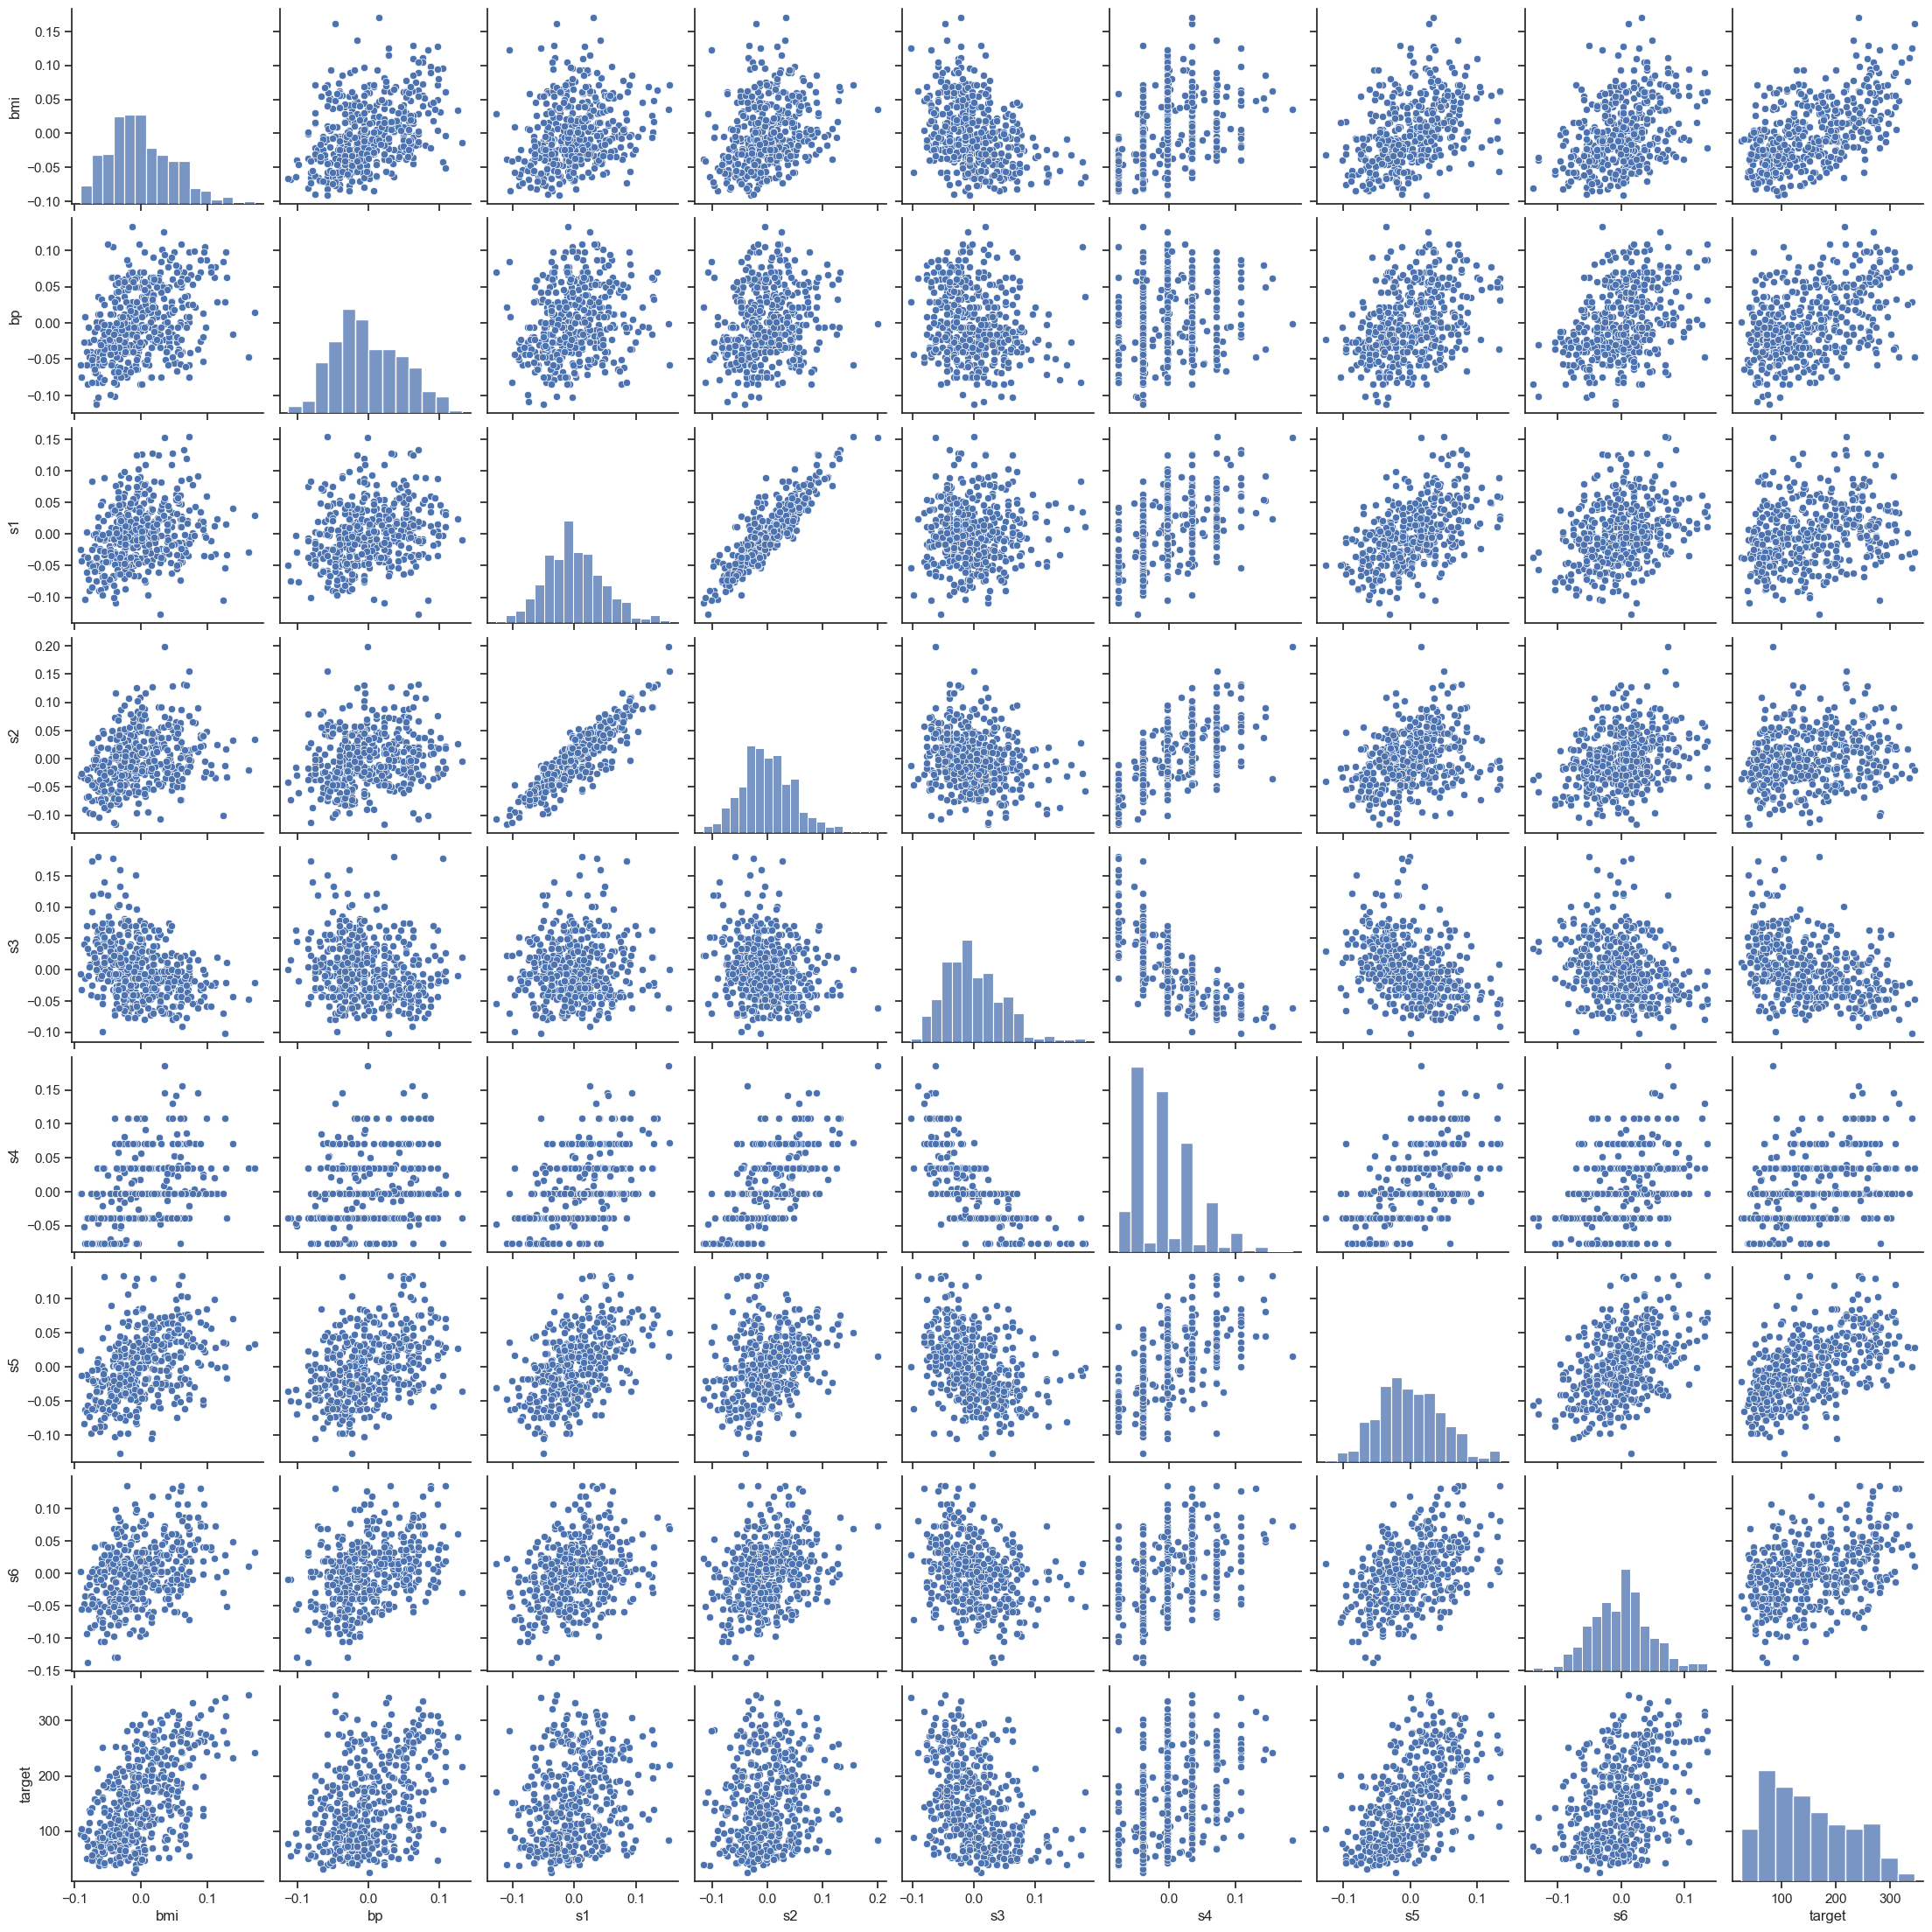

In [71]:
diabetes_df_slice = diabetes_df.loc[:,"bmi":"target"]
sns.set(style="ticks")
sns.pairplot(diabetes_df_slice)
plt.show()

Si procede con l'implementazione dell'heatmap per analizzare la correlazione tra le variabili

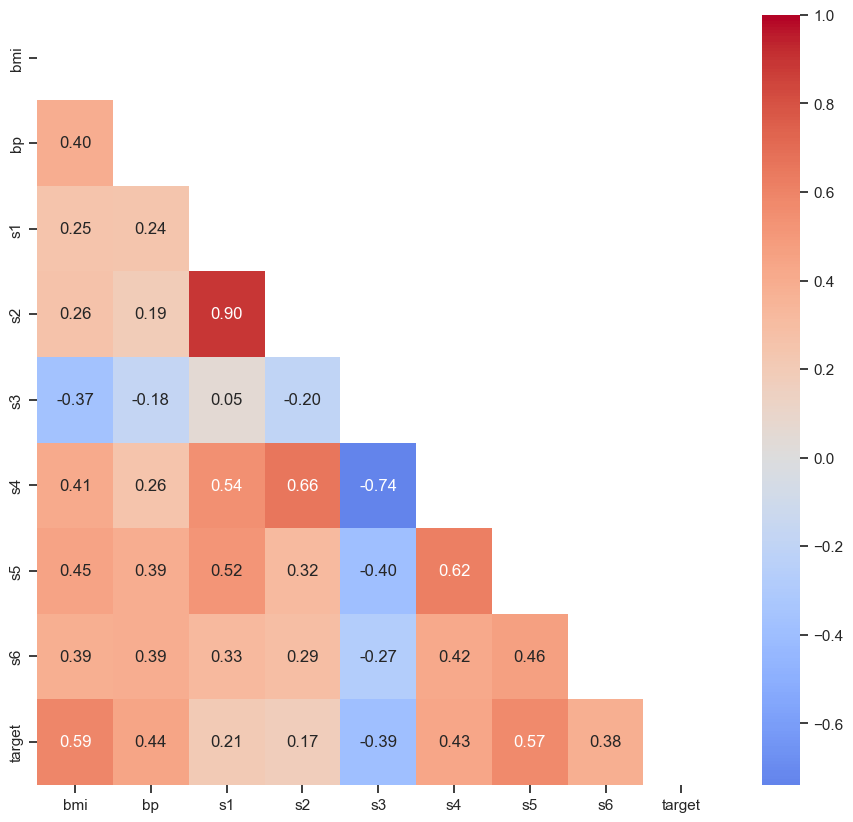

In [72]:
corr = diabetes_df_slice.corr()

def draw_graph_corr(correlation):
    plt.figure(figsize=(11, 10))

    cmap=sns.color_palette("coolwarm", as_cmap=True)
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, vmax=1, center=0, cmap=cmap, annot=True, fmt='.2f')
    plt.show()


draw_graph_corr(corr)

analizzando l'heatmap, si può constatare che:
1. E' presente una correlazione positiva tra il target e le variabili bmi, s4, s5
2. E' presente una correlazione moderata tra il target e le variabili bp, s6
3. E' presente una correlazione debole tra il target e le variabili s1, s2
4. E' presente una correlazione negativa tra il target e la variabile s3

la maggior parte delle variabili hanno una correlazione positiva con il target e avendo una distribuzione lineare approssimata, si potrebbe utilizzare come modello di apprendimento la regressione lineare o SVR. Dovendo scegliere un solo modello da analizzare, vorrei approfondire e valutare le performance del SVR

S'inizia dividendo il dataset in training (70% del dataset) e test set (30% del dataset)

In [73]:
X, y = diabetes.data, diabetes.target
"""
campionamento casuale 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

inizio con il cross validation, cercando i migliori valori per gli iperparametri da analizzare:


1.   C
2.   ϵ
3.   kernel

S'inizia con la ricerca del giusto valore del C e kernel

In [74]:
def create_val_curve(hyper_parameter, kernel_type, title_plot = "Validation Score"):
  param_range = np.logspace(-7, 3, 60)
  train_score, val_score = validation_curve(
      estimator=svm.SVR(kernel=kernel_type), X=X_train, y=y_train, param_name=hyper_parameter, param_range=param_range, cv=7, scoring='neg_mean_squared_error', n_jobs=-1
      )

  plt.xticks(np.arange(min(param_range), max(param_range)+1, 100))
  sns.lineplot(x=param_range, y=np.median(train_score, 1), color='blue', label='training score')
  sns.lineplot(x=param_range, y=np.median(val_score, 1), color='red', label='validation score')
  plt.legend(loc='best')
  plt.xlabel(hyper_parameter)
  plt.ylabel('score')
  plt.title(title_plot)

  plt.show()

ho inserito la mediana perchè le distribuzioni viste nella parte della visualizzazione dei dati, non è del tutto normale

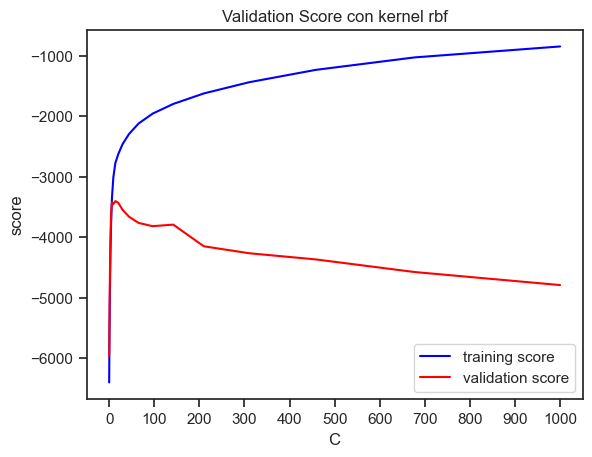

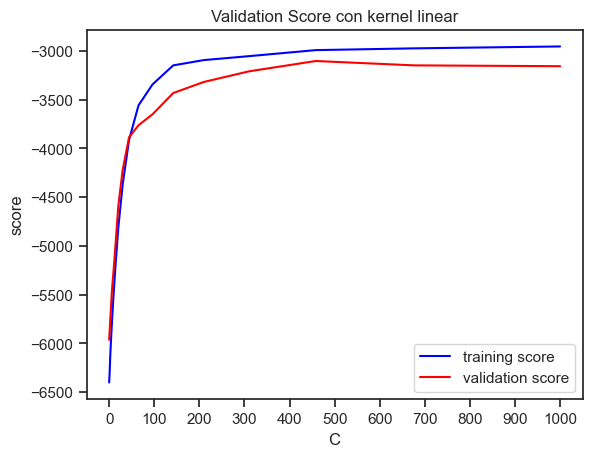

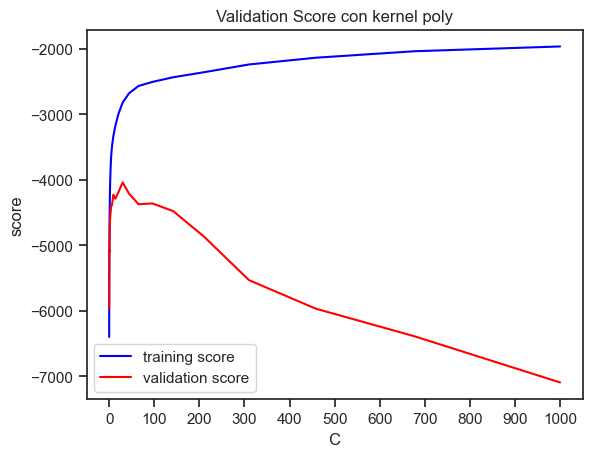

In [75]:
create_val_curve("C", "rbf", "Validation Score con kernel rbf")
create_val_curve("C", "linear", "Validation Score con kernel linear")
create_val_curve("C", "poly", "Validation Score con kernel poly")

Dai grafici in cui sono stati utilizzati i kernel: 
1. **poly** 
2. **rbf** 



emerge che c'è underfitting. Si può notare come le linee del training e validation score sono divergenti, indicando un elevato bias che potrebbe essere non adatto per il modello preso in considerazione, probabilmente un kernel troppo complesso per i dati a disposizione. Ma il miglior grafico che ci può dare degli ottimi spunti è il grafico in cui viene utilizzato il kernel **lineare**: le due linee sono asintotiche, c'è un picco e in seguito aumentano asintoticamente e probabilmente si potrebbe trovare un equilibrio tra bias e varianza utilizzando i valori inseriti nei due parametri

utilizzando lo score del MSE (acronimo di Mean Squared Error, Errore Quadrato Medio, è una misura che confronta il valore che è stato predetto con il valore osservato), bisogna prendere il valore più piccolo dello validation score, perchè un valore basso comporta una maggiore accuratezza del modello, con la libreria GridsearchCV si saprà meglio qual è il miglior parametro

Si procede prendendo in considerazione l'iperparametro **ϵ**

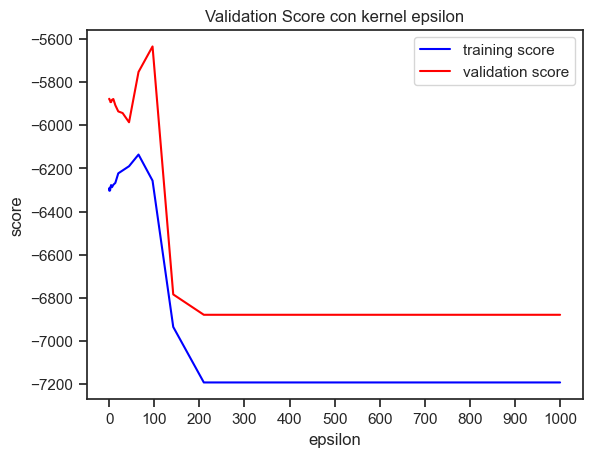

In [76]:
create_val_curve("epsilon", "linear", "Validation Score con kernel epsilon")

in questo grafico le linee del validaton e training score sono asintotiche quindi il valore più basso può portare ad un trade-off tra bias e varianza, non è molto comprensibile qual è il miglior valore per questo parametro, la GridSearchCV ci potrebbe aiutare.

La validation curve ha dato delle prime informazioni sul tuning degli iperparametri. La classe gridsearchcv aiuterà a eseguire una ricerca esaustiva nella ricerca del valore degli iperparametri più adatti per il modello che è stato considerato. i valori inseriti negli iperparametri sono identici a quelli inseriti nel validation curve.

In [77]:
parameters = {
    'C': np.logspace(-7, 3, 60),
    'epsilon': np.logspace(-7, 3, 60)
}

dopo creato i parametri, posso passarli a *GridsearchCV*

In [87]:
gsc = GridSearchCV(svm.SVR(kernel='linear'), parameters, cv=7, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')

Nell' GridSearchCV è stato inserito:
1. il modello SVR come kernel linear per le motivazione inserite nel fase precedente
2. i valori degli iperparametri che saranno array di 60 valori equamente distribuiti su una scala logaritmica compresi da 10^-7 e 10^3
3. Cross validation con la divisione di 7 fold del dataset
4. Come metrica è stata inserita la MSE negativa, utilizzata anche per il validation curve

faccio il training di dati con la gridsearchcv

In [79]:
gsc.fit(X_train, y_train)
gsc.best_estimator_, gsc.best_score_

Fitting 7 folds for each of 3600 candidates, totalling 25200 fits
[CV] END .............................C=1e-07, epsilon=1e-07; total time=   0.0s
[CV] END .............................C=1e-07, epsilon=1e-07; total time=   0.0s
[CV] END .............................C=1e-07, epsilon=1e-07; total time=   0.0s
[CV] END .............................C=1e-07, epsilon=1e-07; total time=   0.0s
[CV] END .............................C=1e-07, epsilon=1e-07; total time=   0.0s
[CV] END .............................C=1e-07, epsilon=1e-07; total time=   0.0s
[CV] END .............................C=1e-07, epsilon=1e-07; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.4773776525985096e-07; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.4773776525985096e-07; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.4773776525985096e-07; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.4773776525985096e-07; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.477

[CV] END ............C=1e-07, epsilon=3.4863652276780875e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.0811807510766078e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=5.1506780761681216e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.5973122800602523e-05; total time=   0.0s

[CV] END ............C=1e-07, epsilon=3.4863652276780875e-05; total time=   0.0s
[CV] END .............C=1e-07, epsilon=7.609496685459868e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=3.4863652276780875e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.5973122800602523e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=3.4863652276780875e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=2.3598334667821938e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=1.0811807510766078e-05; total time=   0.0s
[CV] END ............C=1e-07, epsilon=3.4863652276780875e-05; total time=   0.0s
[CV] END .............C=1e-

(SVR(C=676.8750009458514, epsilon=5.1506780761681216e-05, kernel='linear'),
 -3149.8442077263126)

sono stati ottenuti i seguenti parametri:
1.   C = 1000 (ADESSO è 676.8750009458514) (16/04 676.8750009458514)
2.   ϵ = 29.82471286216882 (ADESSO è 13.664483492953243) (16/04 5.1506780761681216e-05)

si confronterà l'MSE con i dati di training e con quelli di test


In [82]:
new_svr = svm.SVR(C=676.8750009458514, epsilon=5.1506780761681216e-05, kernel='linear')
new_svr.fit(X_train, y_train)

predictions = new_svr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mse

2866.4055130473484

In questo caso, l'MSE è un valore positivo, il che potrebbe creare confusione nel confrontarlo con il valore ottenuto utilizzando la classe GridSearchCV. Scikit-learn, la libreria che include GridSearchCV, utilizza un valore negativo per massimizzare tutti i punteggi di scoring, sia per la classificazione che per la regressione. Quindi, è una convenzione applicata dalla libreria. Per chiarire, è possibile moltiplicare il valore per -1

In [83]:
neg_mse = -1 * mse
neg_mse

-2866.4055130473484

Si può notare come l'MSE ricavato dai dati di training utilizzando il GridSearchCV e l'MSE ricavato dai dati di test hanno dei valori molto vicini, quindi è stato creato un trade-off tra bias e varianza.

Si analizza un'altra metrica R^2.
R^2 è la percentuale di variazione spiegata dalla relazione tra variabili, il valore è compreso tra 0 e 1:
- Se R^2 = 0 significa che il modello non spiega la variazione nei dati nella variabile dipendente utilizzando le variabili indipendenti
- Se R^2 = 1 siignifica che il modello spiega perfettamente la variazione nei dati della variabile dipendente utilizzando le variabili indipendenti

In [85]:
r2_score(y_test, predictions)

0.46901776640352955

R^2 rappresenta circa il 47% della variazione nei dati della variabile dipendente spiegata dalle variabili indipendenti. Si tratta di una variazione moderata, quindi le 10 variabili indipendenti potrebbero essere in parte non rilevanti o non influenzano significativamente la variabile dipendente.

Ma esistono delle tecniche per ottimizzare le prestazioni di un modello? Si potrebbe provare ad inserire un ensemble method e analizzare se il modello aumenta la sua accuratezza

## ENSEMBLE METHOD

Un ensemble method è una tecnica di machine learning che combinano risultati di più modelli di apprendimento per portare a previsioni più accurate rispetto ad singolo modello.
Per questo progetto verrà utilizzato il **Bagging**, un tipo di ensemble method in cui avviene il campionamento casuale con sostituzione (nella statistica questa tecnica viene chiamata **bootstrap**) dei dati di addestramento per creare dei sottoinsieme di dati diversi. E' stato scelto questo tipo perchè riduce la varianza del modello, caso che avviene quando i dati non sono tanti, come in questo progetto. Dopo aver implementato il bagging, verrà rieseguita la classe GridSearchCv.

In [117]:
parameters = {
    'n_estimators': np.arange(201)
}

svr = svm.SVR(kernel='linear', C=676.8750009458514, epsilon=5.1506780761681216e-05)
bagging = BaggingRegressor(base_estimator=svr, random_state=42)
gsc_bagging = GridSearchCV(bagging, parameters, cv=7, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')
gsc_bagging.fit(X_train, y_train)
gsc_bagging.best_estimator_, gsc_bagging.best_score_, gsc_bagging.best_params_

Fitting 7 folds for each of 201 candidates, totalling 1407 fits
[CV] END .....................................n_estimators=0; total time=   0.0s
[CV] END .....................................n_estimators=0; total time=   0.0s
[CV] END .....................................n_estimators=0; total time=   0.0s
[CV] END .....................................n_estimators=0; total time=   0.0s
[CV] END .....................................n_estimators=0; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=2; total time=   0.0s
[CV] END ....................................

/Users/marcooliva/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7 fits failed out of a total of 1407.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/marcooliva/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marcooliva/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/marcooliva/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_

(BaggingRegressor(base_estimator=SVR(C=676.8750009458514,
                                     epsilon=5.1506780761681216e-05,
                                     kernel='linear'),
                  n_estimators=148, random_state=42),
 -3179.7829989708544,
 {'n_estimators': 148})

In [114]:
svr_test = svm.SVR(C=676.8750009458514, epsilon=5.1506780761681216e-05, kernel='linear')
svr_bagging = BaggingRegressor(base_estimator=svr_test, n_estimators=148, random_state=42)
svr_bagging.fit(X_train, y_train)
prediction_bagging = svr_bagging.predict(X_test)
mse = mean_squared_error(y_test, prediction_bagging)

mse

2808.973679274457